In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter

# XOR dataset

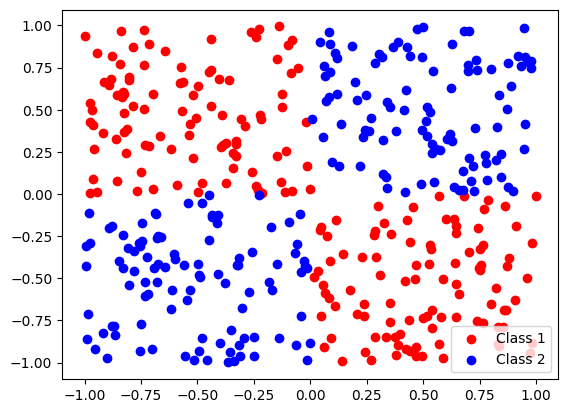

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
x1 = np.concatenate ([np.random.uniform(0,1,100),np.random.uniform(-1,0,100)])
y1 = np.concatenate ([np.random.uniform(-1,0,100),np.random.uniform(0,1,100)])
label1 = np.zeros_like ( x1 ) # create a list of zeros of the same shape as x1 and y1
x2 = np.concatenate ([np.random.uniform(0,1,100),np.random.uniform(-1,0,100)])
y2 = np.concatenate ([np.random.uniform(0,1,100),np.random.uniform(-1,0,100)])
label2 = np.ones_like ( x2 ) # create a list of ones of the same shape as x2 and y2
plt.scatter(x1,y1,c ='red',label ='Class 1')
plt.scatter(x2,y2,c ='blue',label ='Class 2')
plt.legend()
plt.show()

# Decision Tree

In [53]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [54]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            class_probs = np.bincount(y.astype(int), minlength=n_labels)/len(y)
            #print(f"Leaf node: value={leaf_value}")
            print(f"Leaf node: value={leaf_value}, class_probs={class_probs}")
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)
        information_gain = self._information_gain(y, X[:, best_feature], best_thresh)
        print(f"Node: feature={best_feature}, threshold={best_thresh}, information_gain={information_gain}")


        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)
    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r
        
        information_gain = parent_entropy - child_entropy
        return information_gain
    
    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        y = np.round(y).astype(int)
        hist = np.bincount(y)
        ps = hist / len(y)
        return float(-np.sum([p * np.log(p) for p in ps if p > 0]))
        #hist = np.bincount(y)
        #ps = hist / len(y)
        #return -np.sum([p * np.log(p) for p in ps if p>0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)



# Random Forest

In [55]:
#from DecisionTree import DecisionTree
import numpy as np
from collections import Counter

class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_feature=None):
        self.n_trees = n_trees
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.n_features=n_feature
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth,
                            min_samples_split=self.min_samples_split,
                            n_features=self.n_features)
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions

In [56]:
# Merge data and labels
X = np.concatenate((np.column_stack((x1, y1)), np.column_stack((x2, y2))))
y = np.concatenate((label1, label2))

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

In [57]:
clf = DecisionTree(max_depth=10)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

Node: feature=1, threshold=0.9398394229398183, information_gain=0.005198829454179488
Node: feature=1, threshold=0.8879717702319007, information_gain=0.007569296457759278
Node: feature=0, threshold=-0.9793017247366349, information_gain=0.007693945663762025
Leaf node: value=1.0, class_probs=[0. 1.]
Node: feature=0, threshold=-0.9461888434467632, information_gain=0.015604312928992337
Leaf node: value=0.0, class_probs=[1.]
Node: feature=1, threshold=0.7728699587075656, information_gain=0.007037181807735715
Node: feature=0, threshold=0.007843550924897746, information_gain=0.01220226179391981
Node: feature=1, threshold=-0.0031029055406751604, information_gain=0.6430802459583854
Leaf node: value=1.0, class_probs=[0. 1.]
Node: feature=0, threshold=-0.00023633441250869858, information_gain=0.0922160573371918
Leaf node: value=0.0, class_probs=[1.]
Leaf node: value=1.0, class_probs=[0. 1.]
Node: feature=1, threshold=-0.0096326109276339, information_gain=0.6780102022798757
Leaf node: value=0.0, cl

In [58]:
def accuracy(y_pred, y_test):
    return np.sum(np.array_equal(y_pred, y_test)) / len(y_test)

# Accuracy for Decision tree

In [9]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions)

1.0

In [10]:
clf = RandomForest(n_trees=10)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

Node: feature=0, threshold=-0.9149374961445145, information_gain=0.02911827736708683
Node: feature=1, threshold=-0.3858549497407173, information_gain=0.2337916587064593
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=0.0, class_probs=[1.]
Node: feature=1, threshold=0.8577220445949622, information_gain=0.013630933643573373
Node: feature=0, threshold=-0.3907369645049219, information_gain=0.028205426982870763
Node: feature=1, threshold=-0.06194280592411805, information_gain=0.6197478738080744
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=0.0, class_probs=[1.]
Node: feature=1, threshold=0.0637817549777876, information_gain=0.03849332444414455
Node: feature=0, threshold=-0.013991006671769779, information_gain=0.42116988343635015
Node: feature=1, threshold=-0.05008368720093481, information_gain=0.3250829733914482
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=0.0, class_probs=[1.]
Node: feature=1, threshold=-0.002159821022699515, information_gain=0.1425058

Node: feature=0, threshold=-0.9054556428993588, information_gain=0.019217124150622378
Leaf node: value=0.0, class_probs=[1.]
Node: feature=0, threshold=-0.8876126366226614, information_gain=0.015791279513628798
Leaf node: value=1.0, class_probs=[0. 1.]
Node: feature=0, threshold=-0.7847442337075778, information_gain=0.013229047951718864
Node: feature=1, threshold=-0.27463691530770484, information_gain=0.47413931305783735
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=0.0, class_probs=[1.]
Node: feature=0, threshold=-0.3430188720334445, information_gain=0.022497405949246874
Leaf node: value=1.0, class_probs=[0.26 0.74]
Leaf node: value=0.0, class_probs=[0.50595238 0.49404762]
Leaf node: value=1.0, class_probs=[0. 1.]
Node: feature=1, threshold=-0.11277656712002615, information_gain=0.3250829733914482
Leaf node: value=0.0, class_probs=[1.]
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=0.0, class_probs=[1.]
Node: feature=1

# Accuracy for Random Forest 

In [11]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions)

1.0

In [12]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    X_mesh = np.c_[xx.ravel(), yy.ravel()]
    Z = clf.predict(X_mesh.reshape(-1, 2))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(-0.5, 2, 1))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu, edgecolors='black')


# Boundary Visualization

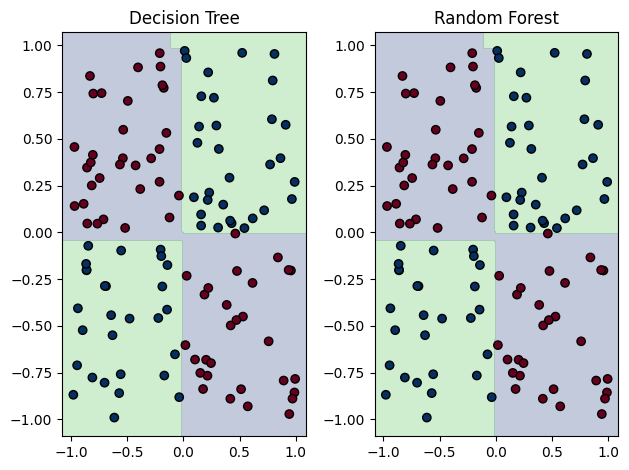

In [13]:
# Plot the decision boundary for the decision tree
plt.subplot(1, 2, 1)
plt.title('Decision Tree')
plot_decision_boundary(DecisionTree, X_test, y_test)
#Plot the decision boundary for the random forest
plt.subplot(1, 2, 2)
plt.title('Random Forest')
plot_decision_boundary(RandomForest, X_test, y_test)
plt.tight_layout()
plt.show()


# Coincentric circle dataset 

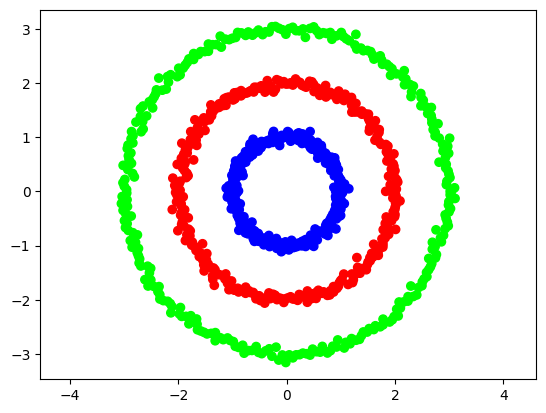

In [14]:
import numpy as np
import matplotlib . pyplot as plt

# Set the number of samples and noise level
n = 300
noise = 0.06

# Generate the data
theta = np . linspace (0 , 2* np . pi , n )
r1 = np . random . normal (0 , noise , n ) + 1
r2 = np . random . normal (0 , noise , n ) + 2
r3 = np . random . normal (0 , noise , n ) + 3
x1 = r1 * np . cos ( theta )
y1 = r1 * np . sin ( theta )
x2 = r2 * np . cos ( theta )
y2 = r2 * np . sin ( theta )
x3 = r3 * np . cos ( theta )
y3 = r3 * np . sin ( theta )
# Concatenate the data and labels
X = np . concatenate ([ np . vstack ([ x1 , y1 ]) , np . vstack ([ x2 , y2 ]) , np . vstack ([ x3 , y3]) ] , axis =1)
y = np.concatenate([np.zeros(n),np.ones(n),np.full(n,2)])
# Plot the data
plt.scatter(X[0,:],X[1,:],c=y,cmap = plt.cm.brg )
plt.axis('equal')
plt.show()


In [15]:
P = np.concatenate([np.vstack([x1, y1]), np.vstack([x2, y2]), np.vstack([x3, y3])], axis=1)
q = np.concatenate([np.zeros(n), np.ones(n), np.full(n, 2)])

In [16]:
P_train, P_test, q_train, q_test = train_test_split(P.T, q, test_size=0.3)

In [17]:
clf = DecisionTree(max_depth=10)
clf.fit(P_train, q_train)
predictions = clf.predict(P_test)

Node: feature=0, threshold=1.1460099650799178, information_gain=0.12025382787857375
Node: feature=0, threshold=-1.124790438004597, information_gain=0.23766797433033748
Node: feature=0, threshold=-2.1161609590577233, information_gain=0.31610853812067197
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Node: feature=1, threshold=-2.1439510096752583, information_gain=0.2645143294077229
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Node: feature=1, threshold=1.7081895126491995, information_gain=0.3960330896236365
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Node: feature=1, threshold=1.1056211864954233, information_gain=0.23535975305915402
Node: feature=1, threshold=-1.5268451356643156, information_gain=0.5043239295398017
Node: feature=1, threshold=-2.7419254317845425, information_gain=0.6855873290398788
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=0.0, class_probs=[1.]
Node: feature=1, threshol

In [18]:
#a=accuracy(q_test,predictions)
#print(a)

# Accuracy for Decision tree

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(q_test, predictions)

0.9888888888888889

In [20]:
clf = RandomForest(n_trees=10)
clf.fit(P_train, q_train)
predictions = clf.predict(P_test)

Node: feature=0, threshold=1.0137577747172482, information_gain=0.13407290490601298
Node: feature=0, threshold=-1.1335612031629299, information_gain=0.25461500336426734
Node: feature=0, threshold=-2.1161609590577233, information_gain=0.2883843724537437
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Node: feature=1, threshold=-2.1439510096752583, information_gain=0.23283895863177956
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Node: feature=1, threshold=1.7081895126491995, information_gain=0.4361623253853443
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Node: feature=1, threshold=-1.6323853065559524, information_gain=0.21699337793013485
Node: feature=1, threshold=-2.7419254317845425, information_gain=0.6864755255818468
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Leaf node: value=1.0, class_probs=[0. 1.]
Node: feature=1, threshold=1.1056211864954233, information_gain=0.47413931305783724
Leaf node: value=0.0, class_probs=[1.]
Node: feature=1, thresh

Node: feature=0, threshold=-1.6207305087709933, information_gain=0.24114578654326235
Node: feature=0, threshold=-2.755167486280292, information_gain=0.6024402635203422
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Leaf node: value=1.0, class_probs=[0. 1.]
Node: feature=0, threshold=1.1460099650799178, information_gain=0.4806759419442619
Leaf node: value=0.0, class_probs=[1.]
Node: feature=0, threshold=2.090360744660476, information_gain=0.6821327446122378
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Node: feature=1, threshold=2.0432999813356405, information_gain=0.30594193572291095
Node: feature=0, threshold=1.7077747107771752, information_gain=0.2877183357845848
Node: feature=0, threshold=-2.1817724701737866, information_gain=0.40294135786694235
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Node: feature=1, threshol

# Accuracy for Random Forest

In [21]:
from sklearn.metrics import accuracy_score
accuracy_score(q_test, predictions)

0.9888888888888889

# Boundary Visualization

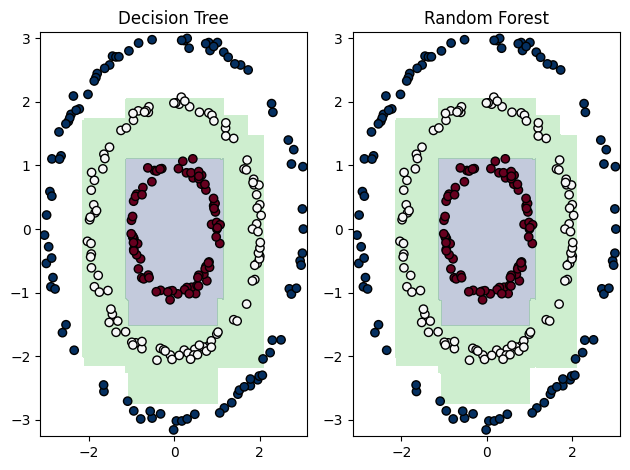

In [22]:
# Plot the decision boundary for the decision tree
plt.subplot(1, 2, 1)
plt.title('Decision Tree')
plot_decision_boundary(DecisionTree, P_test, q_test)
#Plot the decision boundary for the random forest
plt.subplot(1, 2, 2)
plt.title('Random Forest')
plot_decision_boundary(RandomForest, P_test, q_test)
plt.tight_layout()
plt.show()

# Unbalanced Spiral dataset

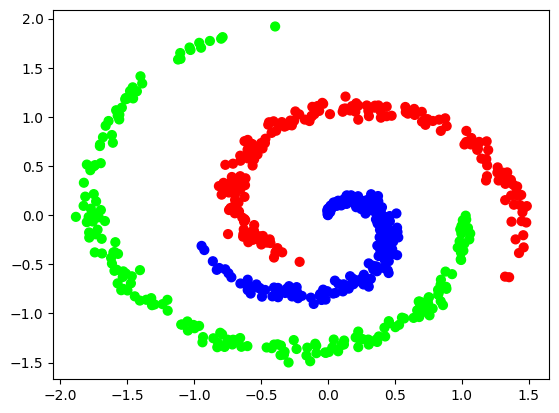

In [23]:
N = 200 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix ( each row = single example )
y = np.zeros(N*K,dtype='uint8') # class labels
for j in range (K):
    ix = range (N*j,N*(j+1))
    r = np.linspace (0.0,1,N) # radius
    r = r+j*0.5
    t = np.linspace(j*4,(j+1)*4,N)+np.random.randn(N)*0.2 # theta
    X[ix]=np.c_[r*np.sin(t),r*np.cos(t)]
    y[ix]=j
spiral4 = np.column_stack((X,y))
plt.scatter(X[:,0],X[:,1],c=y,s=40,cmap='brg')
plt.show()


In [24]:
A_train, A_test, b_train, b_test = train_test_split(X,y, test_size=0.3)

In [25]:
clf = DecisionTree(max_depth=5)
clf.fit(A_train, b_train)
predictions = clf.predict(A_test)

Node: feature=1, threshold=0.21404775346333937, information_gain=0.2181407924104074
Node: feature=1, threshold=-0.869085214206038, information_gain=0.2545696679414189
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=-1.2001448666913355, information_gain=0.21721924003638537
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=0.5262131244835382, information_gain=0.2923533380097548
Node: feature=0, threshold=-0.21135550598901834, information_gain=0.2771189687623792
Leaf node: value=1, class_probs=[0.4 0.6]
Leaf node: value=0, class_probs=[1.]
Node: feature=0, threshold=1.0641258964483786, information_gain=0.6108643020548935
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=1, class_probs=[0. 1.]
Node: feature=0, threshold=-0.7982501082514478, information_gain=0.4771537592369202
Node: feature=1, threshold=0.2952980062982158, information_gain=0.1732052067491771
Leaf node: value=1, class_probs=[0. 1.]
Leaf node: value=2, class_probs=[0. 0. 1.]

# Accuracy for Decision tree

In [26]:
from sklearn.metrics import accuracy_score
accuracy_score(b_test,predictions)

0.9388888888888889

In [27]:
clf = RandomForest(n_trees=10)
clf.fit(A_train, b_train)
predictions = clf.predict(A_test)

Node: feature=0, threshold=-0.9631576069701552, information_gain=0.23467962877732362
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=1, threshold=0.2020455389676227, information_gain=0.2688587147884617
Node: feature=0, threshold=0.52029551159019, information_gain=0.2294290003238436
Node: feature=1, threshold=-1.098943386246917, information_gain=0.3456552647558554
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=-0.21135550598901834, information_gain=0.2686844799420879
Node: feature=1, threshold=-0.6568694177290312, information_gain=0.46816026219631196
Leaf node: value=0, class_probs=[1.]
Node: feature=0, threshold=-0.8603575041133331, information_gain=0.329544105160137
Leaf node: value=0, class_probs=[1.]
Leaf node: value=1, class_probs=[0. 1.]
Leaf node: value=0, class_probs=[1.]
Node: feature=0, threshold=1.0641258964483786, information_gain=0.5159878967418371
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=1, class_probs=[0. 1.]
Leaf node: v

Node: feature=1, threshold=0.21404775346333937, information_gain=0.22369896217193608
Node: feature=1, threshold=-0.869085214206038, information_gain=0.24402043746877988
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=-0.3418248222935318, information_gain=0.21925595273221088
Node: feature=0, threshold=-1.2001448666913355, information_gain=0.6276116833595443
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=1, threshold=-0.4690287734158834, information_gain=0.5179404994071264
Leaf node: value=0, class_probs=[1.]
Node: feature=0, threshold=-0.9445290338410585, information_gain=0.11690684913753106
Leaf node: value=0, class_probs=[1.]
Leaf node: value=1, class_probs=[0. 1.]
Node: feature=0, threshold=0.5262131244835382, information_gain=0.38046910890422003
Node: feature=0, threshold=-0.21135550598901834, information_gain=0.01895457201969174
Node: feature=1, threshold=-0.7226232656885963, information_gain=0.34883209584303193
Leaf node: value=0, class_probs=[1.]
L

# Accuracy for Random Forest 

In [28]:
from sklearn.metrics import accuracy_score
accuracy_score(b_test,predictions)

0.95

# Boundary Visualization

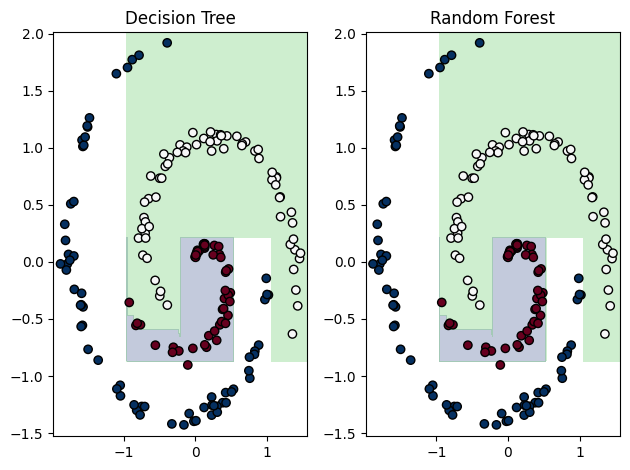

In [29]:
# Plot the decision boundary for the decision tree
plt.subplot(1, 2, 1)
plt.title('Decision Tree')
plot_decision_boundary(DecisionTree, A_test, b_test)
#Plot the decision boundary for the random forest
plt.subplot(1, 2, 2)
plt.title('Random Forest')
plot_decision_boundary(RandomForest, A_test, b_test)
plt.tight_layout()
plt.show()

# Balanced Spiral dataset

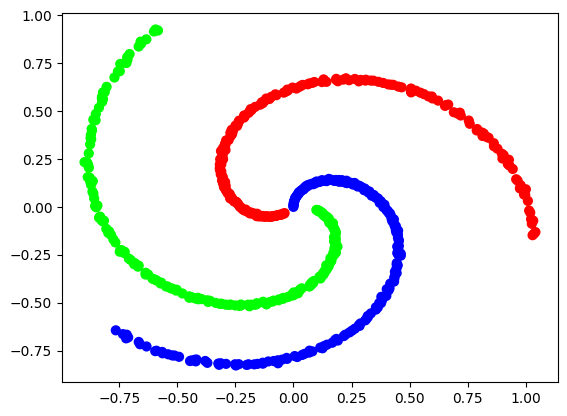

In [30]:
import numpy as np
N = 200 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np . zeros (( N *K , D ) ) # data matrix ( each row = single example )
y = np . zeros ( N *K , dtype ='uint8') # class labels
for j in range ( K ) :
    ix = range (N *j , N *( j +1) )
    r = np . linspace (0.0 ,1 , N ) # radius
    r = r + j *0.05
    # print (r)
    t = np . linspace ( j *4 ,( j +1) *4 , N ) + np . random . randn ( N ) *0.02 # theta
    # print (t)
    X [ ix ] = np . c_ [ r * np . sin ( t ) , r * np . cos ( t ) ]
    y [ ix ] = j
spiral5 = np . column_stack (( X , y ) )
np . savetxt ("spiral3u.csv", spiral5 , delimiter =",", header ="x,y,label", comments
="", fmt ='%.5f')
plt . scatter ( X [: , 0] , X [: , 1] , c =y , s =40 , cmap ='brg')
plt . show ()

In [31]:
A_train, A_test, b_train, b_test = train_test_split(X,y, test_size=0.3)

In [32]:
clf = DecisionTree(max_depth=5)
clf.fit(A_train, b_train)
predictions = clf.predict(A_test)

Node: feature=1, threshold=0.15523019699302576, information_gain=0.2008201582981608
Node: feature=0, threshold=0.18967067159095938, information_gain=0.17042726704460953
Node: feature=1, threshold=-0.6444909275304259, information_gain=0.2564334492574746
Leaf node: value=0, class_probs=[1.]
Node: feature=1, threshold=-0.053469162078005485, information_gain=0.43950106302470154
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=-0.037957394389555296, information_gain=0.5657327231144765
Leaf node: value=1, class_probs=[0.         0.78723404 0.21276596]
Leaf node: value=0, class_probs=[0.84615385 0.         0.15384615]
Node: feature=0, threshold=0.46202507308026425, information_gain=0.3460050960464662
Leaf node: value=0, class_probs=[1.]
Leaf node: value=1, class_probs=[0. 1.]
Node: feature=0, threshold=-0.5935434912856412, information_gain=0.5982695885852573
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=1, class_probs=[0. 1.]


# Accuracy for Decision tree

In [33]:
from sklearn.metrics import accuracy_score
accuracy_score(b_test,predictions)

0.9444444444444444

In [34]:
clf = RandomForest(n_trees=10)
clf.fit(A_train, b_train)
predictions = clf.predict(A_test)

Node: feature=1, threshold=-0.053469162078005485, information_gain=0.19511036606008114
Node: feature=0, threshold=0.18967067159095938, information_gain=0.2801177549796726
Node: feature=1, threshold=-0.6444909275304259, information_gain=0.5739644913933235
Leaf node: value=0, class_probs=[1.]
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=0.4540698708228944, information_gain=0.2787693717685874
Leaf node: value=0, class_probs=[1.]
Leaf node: value=1, class_probs=[0. 1.]
Node: feature=0, threshold=-0.6003609318607628, information_gain=0.4102690750814795
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=-0.026358271355251192, information_gain=0.2626187977341146
Leaf node: value=1, class_probs=[0. 1.]
Node: feature=1, threshold=0.14602029932345165, information_gain=0.4788659123504373
Node: feature=0, threshold=0.39688725971468175, information_gain=0.29543919187211604
Node: feature=1, threshold=-0.0159132783970775, information_gain=0.2772159299810117

Node: feature=1, threshold=-0.07211946765808482, information_gain=0.1861158048593492
Node: feature=1, threshold=-0.5243232154364549, information_gain=0.33888051771111427
Leaf node: value=0, class_probs=[1.]
Node: feature=0, threshold=0.18967067159095938, information_gain=0.5646314060861084
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=0.4540698708228944, information_gain=0.3250829733914482
Leaf node: value=0, class_probs=[1.]
Leaf node: value=1, class_probs=[0. 1.]
Node: feature=0, threshold=-0.5935434912856412, information_gain=0.33976503760129995
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=-0.02421484390202375, information_gain=0.25479117148444097
Leaf node: value=1, class_probs=[0. 1.]
Node: feature=1, threshold=0.14602029932345165, information_gain=0.4711132913367982
Node: feature=1, threshold=-0.0159132783970775, information_gain=0.30496599869196395
Node: feature=0, threshold=0.15304832538987329, information_gain=0.6920129648318738

# Accuracy for Random Forest

In [35]:
from sklearn.metrics import accuracy_score
accuracy_score(b_test,predictions)

0.9722222222222222

# Boundary Visualization

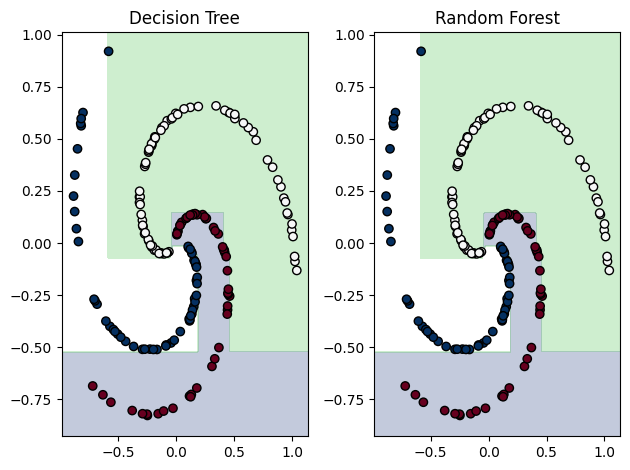

In [36]:
# Plot the decision boundary for the decision tree
plt.subplot(1, 2, 1)
plt.title('Decision Tree')
plot_decision_boundary(DecisionTree, A_test, b_test)
#Plot the decision boundary for the random forest
plt.subplot(1, 2, 2)
plt.title('Random Forest')
plot_decision_boundary(RandomForest, A_test, b_test)
plt.tight_layout()
plt.show()

# Unbalanced Spiral dataset

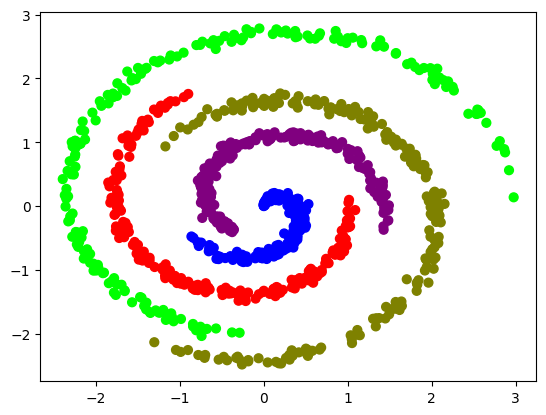

In [37]:
N = 200 # number of points per class
D = 2 # dimensionality
K = 5 # number of classes
X = np . zeros (( N *K , D ) ) # data matrix ( each row = single example )
y = np . zeros ( N *K , dtype ='uint8') # class labels
for j in range ( K ) :
    ix = range (N *j , N *( j +1) )
    r = np . linspace (0.0 ,1 , N ) # radius
    r = r + j *0.5
    t = np.linspace(j *4 ,( j +1) *4 , N ) + np . random . randn ( N ) *0.2 # theta
    # print (t)
    X [ ix ] = np.c_[r*np.sin(t),r*np.cos(t)]
    y [ ix ] = j
spiral4 = np.column_stack((X,y))
plt.scatter(X[:,0],X[:,1],c=y,s=40,cmap ='brg')
plt.show()


In [38]:
A_train, A_test, b_train, b_test = train_test_split(X,y, test_size=0.3)

In [39]:
clf = DecisionTree(max_depth=5)
clf.fit(A_train, b_train)
predictions = clf.predict(A_test)

Node: feature=1, threshold=0.25317724051243845, information_gain=0.21352952500782418
Node: feature=1, threshold=-0.8887008466512613, information_gain=0.26521379985982296
Node: feature=1, threshold=-1.494796172678312, information_gain=0.42186675696117937
Node: feature=0, threshold=-0.2880434489537743, information_gain=0.35643002214612335
Node: feature=1, threshold=-2.2844288095463123, information_gain=0.5908422462755826
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Node: feature=0, threshold=-1.6950405248526006, information_gain=0.36788410016077855
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Node: feature=0, threshold=0.7623060605267133, information_gain=0.2840900943735547
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Node: feature=0, threshold=1.0280146222690516, information_gain=0.30465609719777054
Node: feature=0, threshold=-1.3603489125713866

# Accuracy for Decision tree

In [40]:
from sklearn.metrics import accuracy_score
accuracy_score(b_test,predictions)

0.8733333333333333

In [41]:
clf = RandomForest(n_trees=10)
clf.fit(A_train, b_train)
predictions = clf.predict(A_test)

Node: feature=0, threshold=-0.9001581454921772, information_gain=0.2297103285625921
Node: feature=0, threshold=-1.916878634376021, information_gain=0.22979491870126678
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Node: feature=1, threshold=1.707433347239217, information_gain=0.2152420461981519
Node: feature=1, threshold=-1.185067986329769, information_gain=0.37162471140158126
Node: feature=1, threshold=-2.2844288095463123, information_gain=0.25731864054383163
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Node: feature=1, threshold=1.460650151077242, information_gain=0.12422643236067209
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=-1.7961586411007227, information_gain=0.6931471805599453
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=-1.0336338064766641, information_gain=0.19144408195771734
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
L

Node: feature=1, threshold=-0.8887008466512613, information_gain=0.39137971726025056
Node: feature=1, threshold=-2.2161738918480327, information_gain=0.6002414407455903
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=0.5317330314477152, information_gain=0.4864271270104816
Leaf node: value=0, class_probs=[1.]
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=1.4837066278317557, information_gain=0.2905611395772313
Node: feature=1, threshold=-1.7547989430986002, information_gain=0.666278442414676
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Leaf node: value=1, class_probs=[0. 1.]
Node: feature=0, threshold=2.1529838785866735, information_gain=0.10126481756679193
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Node: feature=1, threshold=1.142678524200697, information_gain=0.3066613807924635
Node: feature=0, threshold=1.4186251337512397, information_gain=0.

Node: feature=0, threshold=-0.9517416902796073, information_gain=0.07757003769329317
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Node: feature=1, threshold=1.7655775533825053, information_gain=0.04488176353418733
Node: feature=0, threshold=-1.748660108195481, information_gain=0.5623351446188083
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Node: feature=1, threshold=0.4092840130518738, information_gain=0.21667424045289607
Node: feature=0, threshold=-1.0673676796786586, information_gain=0.244917928687848
Node: feature=0, threshold=-1.9770059976565613, information_gain=0.4073580836555438
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Node: feature=1, threshold=-1.185067986329769, information_gain=0.336495757583516
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Leaf node: value=2, class_probs=[0.

Node: feature=0, threshold=0.503303560437911, information_gain=0.4654288838286808
Leaf node: value=0, class_probs=[1.]
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=1.4899037358924043, information_gain=0.20340736890076644
Node: feature=0, threshold=1.373874540808306, information_gain=0.6905939864775922
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Leaf node: value=1, class_probs=[0. 1.]
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Node: feature=1, threshold=1.148012917217829, information_gain=0.30024524986543644
Node: feature=0, threshold=-1.6123095583288969, information_gain=0.4367070991258065
Node: feature=0, threshold=-2.1296994008422523, information_gain=0.6295012608763815
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=1.4186251337512397, information_gain=0.3993075247321366
Node: feature=0, threshold=-1.0727757359864358, information_gain=0.1184555428743251
Leaf node: value=3, class_prob

# Accuracy for Random Forest 

In [42]:
from sklearn.metrics import accuracy_score
accuracy_score(b_test,predictions)

0.9633333333333334

# Data Visualization

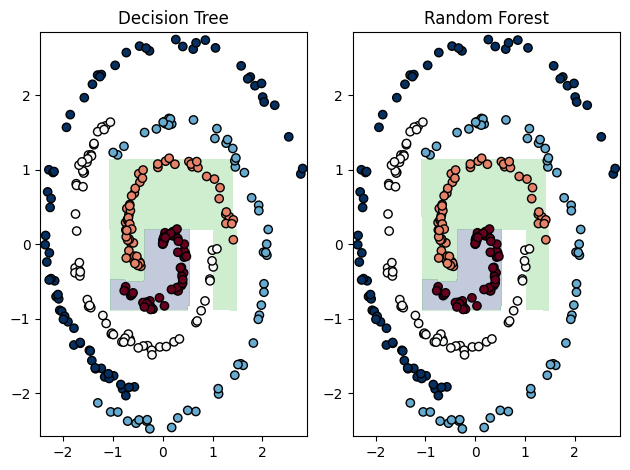

In [43]:
# Plot the decision boundary for the decision tree
plt.subplot(1, 2, 1)
plt.title('Decision Tree')
plot_decision_boundary(DecisionTree, A_test, b_test)
#Plot the decision boundary for the random forest
plt.subplot(1, 2, 2)
plt.title('Random Forest')
plot_decision_boundary(RandomForest, A_test, b_test)
plt.tight_layout()
plt.show()

#  Balanced Spiral dataset

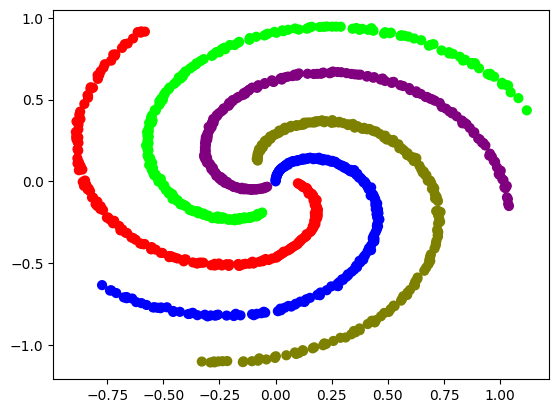

In [44]:
N = 200 # number of points per class
D = 2 # dimensionality
K = 5 # number of classes
X = np . zeros (( N *K , D ) ) # data matrix ( each row = single example )
y = np . zeros ( N *K , dtype ='uint8') # class labels
for j in range ( K ) :
    ix = range (N *j , N *( j +1) )
    r = np . linspace (0.0 ,1 , N ) # radius
    r = r + j *0.05
    # print (r)
    t = np . linspace ( j *4 ,( j +1) *4 , N ) + np . random . randn ( N ) *0.02 # theta
    # print (t)
    X [ ix ] = np . c_ [ r * np . sin ( t ) , r * np . cos ( t ) ]
    y [ ix ] = j
spiral5 = np . column_stack (( X , y ) )
plt . scatter ( X [: , 0] , X [: , 1] , c =y , s =40 , cmap ='brg')
plt . show ()

In [45]:
A_train, A_test, b_train, b_test = train_test_split(X,y, test_size=0.3)

In [46]:
clf = DecisionTree(max_depth=5)
clf.fit(A_train, b_train)
predictions = clf.predict(A_test)

Node: feature=1, threshold=-0.24081009056787966, information_gain=0.17461062703406682
Node: feature=1, threshold=-0.522966287190692, information_gain=0.33565457896261464
Node: feature=1, threshold=-0.8625901100996765, information_gain=0.3433928685050787
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Node: feature=0, threshold=0.36273512294046795, information_gain=0.48691270946460224
Leaf node: value=0, class_probs=[1.]
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Node: feature=0, threshold=0.17717962843888552, information_gain=0.6116846784413298
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=0.4561644161126523, information_gain=0.650390640876698
Leaf node: value=0, class_probs=[1.]
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Node: feature=0, threshold=-0.32013886519836887, information_gain=0.2473208319991853
Node: feature=0, threshold=-0.5821975522340587, information_gain=0.692378048326593
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=4, class_pro

# Accuracy for Decision tree

In [47]:
from sklearn.metrics import accuracy_score
accuracy_score(b_test,predictions)

0.8366666666666667

In [48]:
clf = RandomForest(n_trees=10)
clf.fit(A_train, b_train)
predictions = clf.predict(A_test)

Node: feature=1, threshold=-0.24081009056787966, information_gain=0.17942154746803118
Node: feature=1, threshold=-0.522966287190692, information_gain=0.30531671805286864
Node: feature=1, threshold=-0.8625901100996765, information_gain=0.4779338133592791
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Node: feature=0, threshold=0.3569386917382039, information_gain=0.34377956394459236
Leaf node: value=0, class_probs=[1.]
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Node: feature=0, threshold=0.17717962843888552, information_gain=0.6342473702280785
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=0.4561644161126523, information_gain=0.6295012608763815
Leaf node: value=0, class_probs=[1.]
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Node: feature=0, threshold=-0.33358763291057786, information_gain=0.2536398786374605
Node: feature=0, threshold=-0.5821975522340587, information_gain=0.6839884329677817
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=4, class_pr

Node: feature=1, threshold=0.6714294500995377, information_gain=0.40413579357079676
Node: feature=0, threshold=0.8297733412050394, information_gain=0.3250829733914482
Leaf node: value=1, class_probs=[0. 1.]
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Node: feature=1, threshold=0.1398886721542824, information_gain=0.17928348695626162
Node: feature=0, threshold=-0.015040966847383576, information_gain=0.21093394420495337
Node: feature=1, threshold=-0.6830734590155129, information_gain=0.48955189362292906
Node: feature=1, threshold=-1.0822259622207349, information_gain=0.6894691997751603
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Leaf node: value=0, class_probs=[1.]
Node: feature=1, threshold=-0.053181555812356236, information_gain=0.4066791543745203
Node: feature=1, threshold=-0.25031277054501766, information_gain=0.41121859604196676
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=-0.7464485186059411, informati

Node: feature=0, threshold=-0.33147400665663124, information_gain=0.1975330114670395
Node: feature=0, threshold=-0.5821975522340587, information_gain=0.43573309949813144
Node: feature=1, threshold=-0.6830734590155129, information_gain=0.2967152565836348
Leaf node: value=0, class_probs=[1.]
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=1, threshold=-0.43780358315125517, information_gain=0.5004024235381878
Node: feature=1, threshold=-0.7701199733316397, information_gain=0.5799151714181009
Leaf node: value=0, class_probs=[1.]
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Node: feature=1, threshold=0.3742931899274759, information_gain=0.2508109134386374
Node: feature=1, threshold=-0.05729852824142311, information_gain=0.24144982315585928
Node: feature=0, threshold=0.1885720512309829, information_gain=0.3813253295991077
Node: feature=1, threshold=-0.694097497737123, information_gain=0.5574651697742554
Node: feature=1, threshold=-1.055

Node: feature=1, threshold=-0.24081009056787966, information_gain=0.1954022854194699
Node: feature=1, threshold=-0.522966287190692, information_gain=0.4116923111153348
Node: feature=1, threshold=-0.9100100467770466, information_gain=0.3888082081066385
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Node: feature=0, threshold=0.36273512294046795, information_gain=0.38366200046938814
Leaf node: value=0, class_probs=[1.]
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Node: feature=0, threshold=0.1765753107980478, information_gain=0.4981024725126185
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=0.4529329740728226, information_gain=0.6791932659915256
Leaf node: value=0, class_probs=[1.]
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Node: feature=0, threshold=-0.32013886519836887, information_gain=0.24737349853080626
Node: feature=0, threshold=-0.6715060545667886, information_gain=0.6919213094962968
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=4, class_pro

# Accuracy for Random Forest

In [49]:
from sklearn.metrics import accuracy_score
accuracy_score(b_test,predictions)

0.9433333333333334

# Boundary Visualization

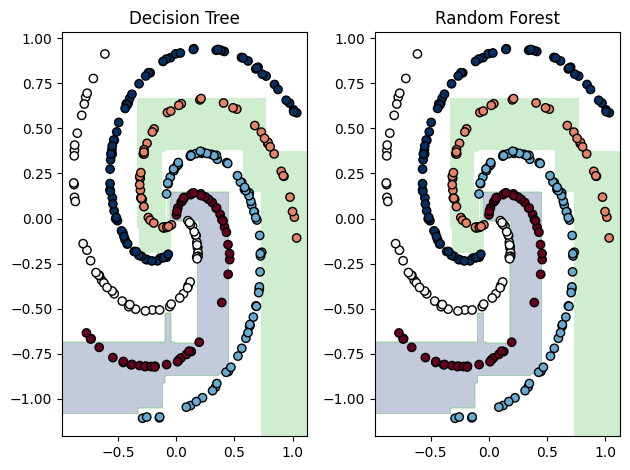

In [50]:
# Plot the decision boundary for the decision tree
plt.subplot(1, 2, 1)
plt.title('Decision Tree')
plot_decision_boundary(DecisionTree, A_test, b_test)
#Plot the decision boundary for the random forest
plt.subplot(1, 2, 2)
plt.title('Random Forest')
plot_decision_boundary(RandomForest, A_test, b_test)
plt.tight_layout()
plt.show()